In [1]:
# Medical Imaging Classification

# Step 1: Data Loading and Sanity Checks

## Goal: Load chest X-ray dataset(Normal vs Pneumonia), verify labels, inspect images,
# and prepare TensorFlow datasets for transfer learning.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

C:\Users\Danie\Desktop\Anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

In [4]:
# Checking where my current folder is 
print("Current working directory:", os.getcwd())

Current working directory: C:\Users\Danie\Desktop\Medical_Imaging_Classification


In [5]:
# Create folder structure
folders = ["data/chest_xray/train/NORMAL",
           "data/chest_xray/train/PNEUMONIA",
           "data/chest_xray/val/NORMAL",
           "data/chest_xray/val/PNEUMONIA",
           "data/chest_xray/test/NORMAL",
           "data/chest_xray/test/PNEUMONIA",]
# Loop through folders
for i in folders:
    # creates folder if it doesn't exist
    os.makedirs(i, exist_ok = True)
print("Folder structure created.")    

Folder structure created.


In [6]:
# Creating folder paths
train_dir = "data/chest_xray/train"
val_dir = "data/chest_xray/val"
test_dir = "data/chest_xray/test"
# Does the files exist if yes it will return true
print("train exists?", os.path.exists(train_dir))
print("val exists?", os.path.exists(val_dir))
print("test exists?", os.path.exists(test_dir))

train exists? True
val exists? True
test exists? True


In [7]:
#Checking if the folders are empty if they are return 0.
def count_images(path):
    # If the directory does not exist, return 0 images
    if not os.path.exists(path):
        return 0
     # Create an empty list to store image filenames   
    image_files = []
    # loop through path, which is every file in directory
    for i in os.listdir(path):
        # if filename is lowercase and ends with png, jpg, or jpeg
        if i.lower().endswith((".png", ".jpg", ".jpeg")):
            # then append image files to the list
            image_files.append(i)
     # call it recursively and return the length of image files found       
    return len(image_files) 
#Validation set images are tiny at 16 so accuracy will jump around alot    
print("Train NORMAL:", count_images("data/chest_xray/train/NORMAL"))
print("Train PNEUMONIA:", count_images("data/chest_xray/train/PNEUMONIA"))
print("Val NORMAL:", count_images("data/chest_xray/val/NORMAL"))
print("Val PNEUMONIA:",count_images("data/chest_xray/val/PNEUMONIA"))
print("Test NORMAL:", count_images("data/chest_xray/test/NORMAL"))
print("Test PNEUMONIA:", count_images("data/chest_xray/test/PNEUMONIA"))

Train NORMAL: 1341
Train PNEUMONIA: 3875
Val NORMAL: 8
Val PNEUMONIA: 8
Test NORMAL: 234
Test PNEUMONIA: 390


In [8]:
# Gives you full training images. Then split into 80/20 split
train_ds = tf.keras.utils.image_dataset_from_directory(
    "data/chest_xray/train",
    validation_split = 0.2,
    subset = "training",
    seed = SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
# same thing for validation set 80/20 split
val_ds = tf.keras.utils.image_dataset_from_directory(
    "data/chest_xray/train",
    validation_split = 0.2,
    subset = "validation",
    seed = SEED,
    image_size=IMAGE_SIZE,
    batch_size = BATCH_SIZE)
# Create the test dataset from the TEST folder.
test_ds=tf.keras.utils.image_dataset_from_directory(
    "data/chest_xray/test",
    image_size=IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = False)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


In [9]:
#Confirm the labels and model output match
#Building the model using transfer learning
base = tf.keras.applications.MobileNetV2(
    input_shape =(224, 224, 3),
    include_top =False,
    weights="imagenet")
#freeze for first training phase, because
# data set is imbalanced I dont want it to overfit.
base.trainable = False
#Input layers
inputs = tf.keras.Input(shape=(224,224, 3))
#preprocessing Input layers
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
# This helps from unstable training and inconsistant training
x = base(x, training=False)
#Reduces overfitting, Converts feature maps to one vector
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#Dropout regularization, good for imbalanced data sets. Forces robustness
x = tf.keras.layers.Dropout(0.2)(x)
#Output layer binary classification think of it as yes or no
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
# Build the model
model = tf.keras.Model(inputs, outputs)

In [10]:
#Define the Cost function(loss)
# Loss tells us how off your model is
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits = False)
#Define the optimizer (gradient descent using Adam )
#Adam is a combination of RMSprop and gradient descent with momentum,
#which makes it alot faster
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
#Define accuracy
metrics = [
    tf.keras.metrics.BinaryAccuracy(name = "accuracy"),
    tf.keras.metrics.AUC(name ="auc")
]

In [11]:
#Compile connects loss, Adam, and metrics together
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=metrics
)

In [12]:
#Train model
#Train the model for 10 epochs
#Each epoch is one full pass over
#the training dataset
#Model weights are updated on every batch using
#Adam to minimize the loss
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10
)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 124s 847ms/step - accuracy: 0.7335 - auc: 0.7442 - loss: 0.5082 - val_accuracy: 0.8236 - val_auc: 0.9339 - val_loss: 0.3868
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 96s 732ms/step - accuracy: 0.8366 - auc: 0.9230 - loss: 0.3714 - val_accuracy: 0.9060 - val_auc: 0.9686 - val_loss: 0.3025
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 146s 762ms/step - accuracy: 0.8967 - auc: 0.9630 - loss: 0.2956 - val_accuracy: 0.9319 - val_auc: 0.9767 - val_loss: 0.2529
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 113s 862ms/step - accuracy: 0.9240 - auc: 0.9738 - loss: 0.2489 - val_accuracy: 0.9453 - val_auc: 0.9801 - val_loss: 0.2212
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 100s 761ms/step - accuracy: 0.9363 - auc: 0.9794 - loss: 0.2201 - val_accuracy: 0.9492 - val_auc: 0.9821 - val_loss: 0.2000
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 101s 770ms/step - accuracy: 0.9360 - auc: 0.9813 - loss: 0.2007 - val_accuracy: 0.9501 - val_auc: 0.9834 - val_loss: 0.1841
Epoch 7/10
131/13

In [13]:
# Evaluate the test set
test_results = model.evaluate(test_ds, verbose=1)
print("Test results:", dict(zip(model.metrics_names,test_results)))

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 632ms/step - accuracy: 0.7965 - auc: 0.9586 - loss: 0.3888    
Test results: {'loss': 0.3888121545314789, 'compile_metrics': 0.7964743375778198}


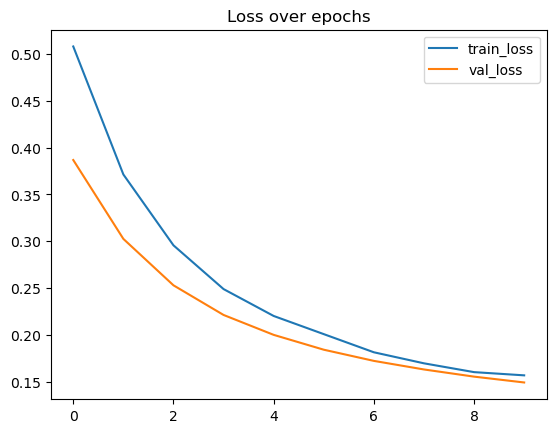

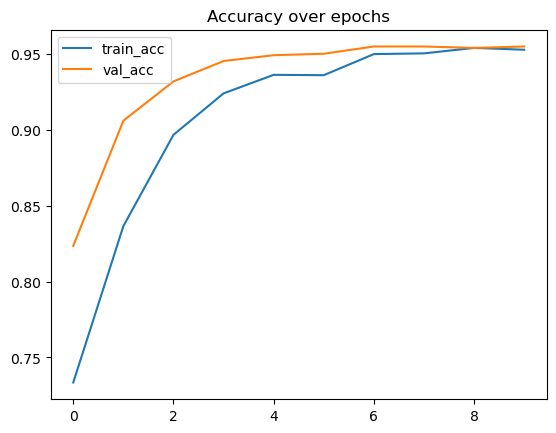

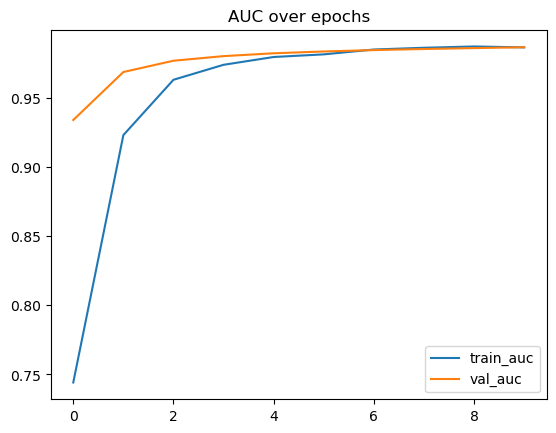

In [14]:
# Plotting the loss and accuracy curves
import matplotlib.pyplot as plt
# Shows the Loss decreasing over many iterations
plt.figure()
plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()
# Accuracy increases over many iterations
plt.figure()
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_accuracy"], label = "val_acc")
plt.legend()
plt.title("Accuracy over epochs")
plt.show()
# Shows AUC increasing over many iterations
plt.figure()
plt.plot(history.history["auc"], label = "train_auc")
plt.plot(history.history["val_auc"], label = "val_auc")
plt.legend()
plt.title("AUC over epochs")
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 586ms/step
[[198  36]
 [ 32 358]]
              precision    recall  f1-score   support

      NORMAL       0.86      0.85      0.85       234
   PNEUMONIA       0.91      0.92      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.88      0.88       624
weighted avg       0.89      0.89      0.89       624



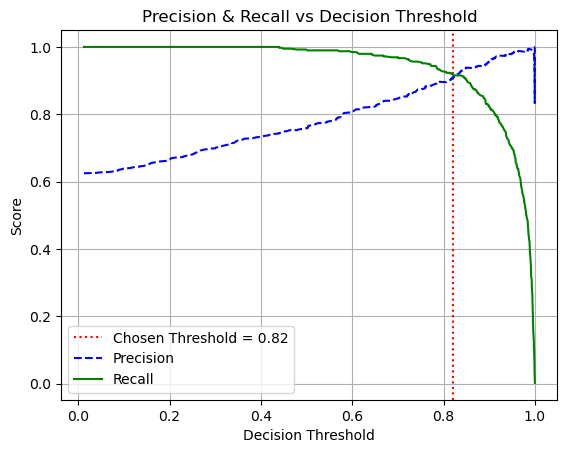

In [16]:
#Confusion matrix and classification report
import numpy as np 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve

y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_prob = model.predict(test_ds).ravel()
# I changed threshold like 5 times it was set to 0.5
# But the recall for PNeumonia was super high and Normal was
# at 47 which is low so I increased the threshold to 0.82
# and the recall now has a balanced performance so both are 
# now recognizing which is Normal and which is Pneumonia
y_pred = (y_prob >= 0.82).astype(int)

#Printing out Confusion matrix results
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

#Precision vs recall
# Trying to find the threshold where recall and Precision are both high
precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
# calling function and attributes I want to call when I start plotting 
# Score vs Theshold to find out which number fits best for the threshold
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[: -1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[: -1], "g-", label = "Recall")
    [...]
# Highlighting the threshold I chose
BEST_THRESHOLD = 0.82
plt.axvline(BEST_THRESHOLD, color = "red", linestyle = ":",
            label = f"Chosen Threshold = {BEST_THRESHOLD}")
#Labeling graph
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Decision Threshold")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# Confirm class order
print("Class names:", train_ds.class_names)

Class names: ['NORMAL', 'PNEUMONIA']


In [18]:
# Predict on One image file
# uses your dataset order
CLASS_NAMES = train_ds.class_names
IMG_SIZE = (224,224)

def predict_image(image_path):
    # Load and resize
    img = tf.keras.utils.load_img(image_path, target_size = IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img)
    img_batch = tf.expand_dims(img_array, axis=0)

    # Predict probability (because your output is sigmoid)
    prob = model.predict(img_batch, verbose=0)[0][0]

    # Convert prob -> label
    # If CLASS_NAMES == ['NORMAL', 'PNEUMONIA'], then prob ~ PNEUMONIA
    pred_index = 1 if prob >= 0.5 else 0
    pred_label = CLASS_NAMES[pred_index]
    confidence = prob if pred_index == 1 else (1 - prob)

    #Show image + results

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {pred_label} | Confidence: {confidence: 3f}")
    plt.show()

    print(f"Raw sigmoid output (prob class=1): {prob:.4f}")
    print(f"Predicted: {pred_label} (confidence {confidence: .4f})")    

In [19]:
#Get validation set
#Get true labels (0/1) form val_ds
y_true = np.concatenate([y.numpy() for x, y in val_ds])

#Get predicted probabilities for class 1 (pneumonia)
y_prob = model.predict(val_ds).ravel()

print("y_true shape:", y_true.shape)
print("y_prob shape:", y_prob.shape)
print("Example probs:", y_prob[:10])


33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 594ms/step
y_true shape: (1043,)
y_prob shape: (1043,)
Example probs: [0.9971444  0.04502603 0.99525887 0.996048   0.8084889  0.146977
 0.9667283  0.99802446 0.9855688  0.9999387 ]


In [20]:
# y_true_list: the ground-truth labels (0 = NORMAL, 1 = PNEUMONIA)
y_true_list = []
# y_prob: the model's predicted probabilites for class 1 (PNEUMONIA)
y_prob_list = []
# iterate the validation dataset batch by batch
for x_batch, y_batch in val_ds:
    # Predict probabilites for each image in the batch
    probs = model.predict(x_batch, verbose=0).ravel()
    # Store true labels and predicted probabilites
    y_true_list.append(y_batch.numpy())
    y_prob_list.append(probs)
# Combine all batches into single arrays    
y_true = np.concatenate(y_true_list)
y_prob = np.concatenate(y_prob_list)

thr | acc | recall_NORMAL |recall_PNEUMONIA
-------------------------------------------
0.30 |  0.936 | 0.743 |  0.996
0.40 |  0.954 | 0.843 |  0.989
0.50 |  0.955 | 0.892 |  0.975
0.60 |  0.950 | 0.932 |  0.956
0.70 |  0.935 | 0.952 |  0.929
0.80 |  0.902 | 0.964 |  0.883
0.90 |  0.832 | 0.992 |  0.782
Test ROC-AUC: 0.9582401928555776


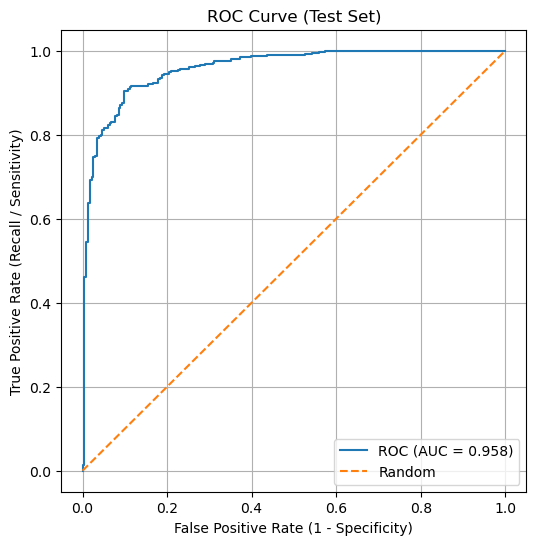

In [21]:
#Use ROC curve to see how good your model is across all thresholds 
#Testing all the thresholds
from sklearn.metrics import recall_score, accuracy_score
# is a list of thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

print("thr | acc | recall_NORMAL |recall_PNEUMONIA")
print("-------------------------------------------")
#stores result in an empty list
results = []
#iterate through the list thresholds
for t in thresholds:
    # Convert probabilites to predicted labels
    y_pred = (y_prob >= t).astype(int) # 1 = pneumonia, 0 = normal
    # Out of all the Normal cases how many did we predict Normal
    recall_normal = recall_score(y_true, y_pred, pos_label = 0)
    # Out of all the Pneumonia cases how many did we predict Pneumonia
    recall_pneu = recall_score(y_true, y_pred, pos_label = 1)
    # Overall accuracy 
    acc = accuracy_score(y_true, y_pred)
    #append results to a list
    results.append((t, acc, recall_normal, recall_pneu))
    # Print readable table row
    print(f"{t:.2f} | {acc: .3f} | {recall_normal:.3f} | {recall_pneu: .3f}")

    
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
    
# Collect y_true (0/1) from the dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds])

# Get predicted probabilities for PNEUMONIA
# If your model ends with sigmoid, model.predict gives probs in [0,1]
y_prob = model.predict(test_ds, verbose=0).ravel()

# ROC points: False positive rates and True positive rates across all thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

# AUC score
auc = roc_auc_score(y_true, y_prob)
print("Test ROC-AUC:", auc)

# Plot ROC curve
# AUC = 0.959, if you randomly pick one pneumonia image and 
# one normal image, there is a 95.9% chance the model assigns a
# higher score to the pneumonia image.
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label = f"ROC (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label = "Random")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall / Sensitivity)")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

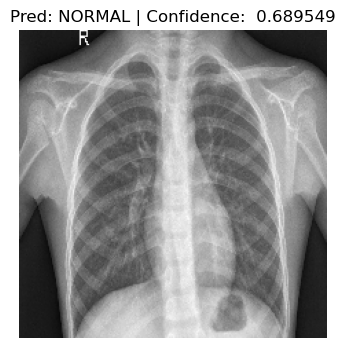

Raw sigmoid output (prob class=1): 0.3105
Predicted: NORMAL (confidence  0.6895)


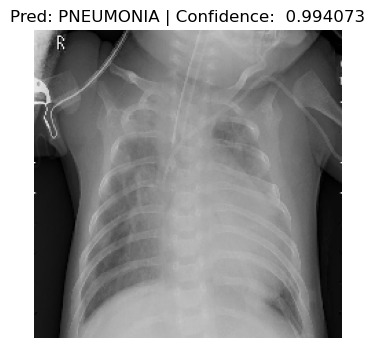

Raw sigmoid output (prob class=1): 0.9941
Predicted: PNEUMONIA (confidence  0.9941)


In [22]:
#Normal
predict_image(r"data/chest_xray/test/NORMAL/IM-0001-0001.jpeg")
#Pneumonia
predict_image(r"data/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg")

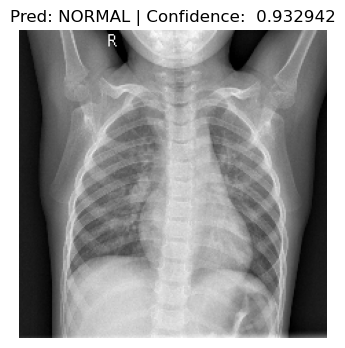

Raw sigmoid output (prob class=1): 0.0671
Predicted: NORMAL (confidence  0.9329)


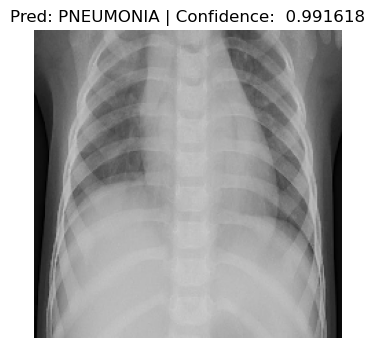

Raw sigmoid output (prob class=1): 0.9916
Predicted: PNEUMONIA (confidence  0.9916)


In [23]:
#Normal
predict_image(r"data/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
#Pneumonia
predict_image(r"data/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg")

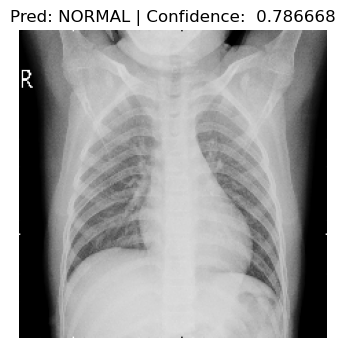

Raw sigmoid output (prob class=1): 0.2133
Predicted: NORMAL (confidence  0.7867)


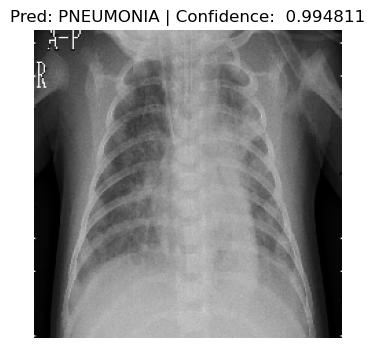

Raw sigmoid output (prob class=1): 0.9948
Predicted: PNEUMONIA (confidence  0.9948)


In [24]:
#Normal 
predict_image(r"data/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg")
predict_image(r"data/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg")